In [1]:
%matplotlib inline

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf

from edward.models import (
    Categorical, Dirichlet, Empirical, InverseGamma,
    MultivariateNormalDiag, Normal, ParamMixture)

plt.style.use('ggplot')

In [10]:
def build_toy_dataset(N):
  pi = np.array([0.4, 0.6])
  mus = [[1, 1], [-1, -1]]
  stds = [[0.1, 0.1], [0.1, 0.1]]
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

  return x


N = 500  # number of data points
K = 2  # number of components
D = 2  # dimensionality of data

ed.set_seed(42)

x_train = build_toy_dataset(N)

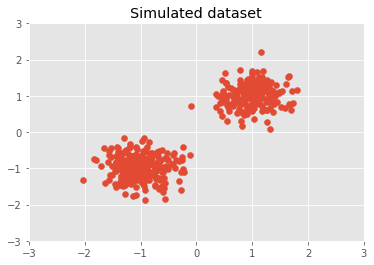

In [11]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.title("Simulated dataset")
plt.show()

In [12]:
pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

In [13]:
T = 500  # number of MCMC samples
qpi = Empirical(tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(tf.Variable(tf.zeros([T, K, D])))
qsigmasq = Empirical(tf.Variable(tf.ones([T, K, D])))
qz = Empirical(tf.Variable(tf.zeros([T, N], dtype=tf.int32)))

In [14]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  if t % inference.n_print == 0:
    print("\nInferred cluster means:")
    print(sess.run(running_cluster_means, {t_ph: t - 1}))

  5/500 [  1%]                                ETA: 192s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.11181679  0.10995651]
 [-0.3997559  -0.33366883]]
 10/500 [  2%]                                ETA: 106s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.54695404  0.56496185]
 [-0.72146595 -0.66574794]]
 15/500 [  3%]                                ETA: 71s | Acceptance Rate: 1.000 
Inferred cluster means:
[[ 0.70037383  0.73166174]
 [-0.82688743 -0.77142859]]
 20/500 [  4%] █                              ETA: 54s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.77287018  0.81307679]
 [-0.87386715 -0.82220155]]
 25/500 [  5%] █                              ETA: 44s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.81779045  0.85631943]
 [-0.90129274 -0.85372168]]
 30/500 [  6%] █                              ETA: 37s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.84801304  0.88444459]
 [-0.92122769 -0.87430501]]
 35/500 [  7%] ██                          

265/500 [ 53%] ███████████████                ETA: 4s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.96819198  1.01020861]
 [-1.00154901 -0.95909917]]
270/500 [ 54%] ████████████████               ETA: 4s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.96866977  1.01017106]
 [-1.00185335 -0.95927107]]
275/500 [ 55%] ████████████████               ETA: 4s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.96939969  1.01056051]
 [-1.00191021 -0.95943522]]
280/500 [ 56%] ████████████████               ETA: 3s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.96977085  1.01072466]
 [-1.00199151 -0.95955592]]
285/500 [ 56%] █████████████████              ETA: 3s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.96973449  1.01098716]
 [-1.00208986 -0.95958269]]
290/500 [ 57%] █████████████████              ETA: 3s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.96994525  1.01141059]
 [-1.00237477 -0.95940846]]
295/500 [ 59%] █████████████████              ETA: 3

In [15]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

In [16]:
# Choose the cluster with the highest likelihood for each data point.
clusters = tf.argmax(log_liks, 1).eval()

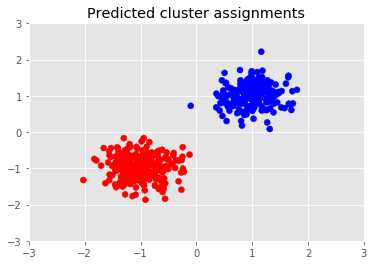

In [17]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()